In [23]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
from open_data  import matlab_file
from structure_data import  manage
from compute.classif import classify

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms

import os
import sys

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and format data

### Load data

In [24]:
#Load
session, data_path, info_path = matlab_file.from_lab(lab_desktop=True, session='t150204001')
data, load_info = matlab_file.open(data_path)
session_info_raw = matlab_file.clean(info_path)


43 files loaded


In [25]:
# get sessions and units information (unit, prob, elitrials)
info_units,  info_session = manage.info(load_info, session_info_raw, session)
unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = manage.units_label(info_units)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(manage.elitrials)
# get unit's index without eli trials 
completeUnit = manage.CompleteTasktime(info_session, load_info, session)
unit_label[:5]

Complete unit found ! 
loading index = 2
matfile : t150204001_probe1_contact3_unit1.mat


['P1-23-2', 'P1-5-1', 'P1-3-1', 'P1-1-1', 'P2-6-1']

In [26]:
spike_times, task_times, target_info = matlab_file.extract_data(\
        load_info, data, target_keys_OFF=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'],\
        target_keys_ON=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], \
        event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

### Format spike times 

In [27]:
event_labels = matlab_file.get_event_labels(task_times)
event_times = matlab_file.get_event_times(task_times, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = manage.events_by_trial(event_times, event_labels)

In [28]:
unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {task_times[0][1].keys()}')


times as list : [3047992 3049069 3050391 3051713 3053021 3054320 3054799]
times as neo events : [3047992. 3049069. 3050391. 3051713. 3053021. 3054320. 3054799.] ms
spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time'])


In [29]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


### Format target

In [30]:
target = manage.target_by_trials(target_info, completeUnit)
target

,trial_type,position,type_and_pos
0,1,2,0
1,1,2,0
2,1,3,1
3,1,3,1
4,1,4,2
...,...,...,...
171,1,3,1
172,2,3,4
173,2,4,5
174,2,4,5


### Format trials

In [31]:
# align times by trials for each neurons
df_task_ts_by_neuron = manage.time_by_trials(df_task_ts_by_neuron, df_task_ts, event_labels)
df_task_ts_by_neuron[0][1]

# split the spike time vector by trial
spk_trials, spike_train_trial = manage.spike_ts_by_trial(trials_ts, spike_times)
spikes_times_aligned = manage.spike_ts_aligned(df_task_ts, df_task_ts_by_neuron, spike_times, unit_label, spike_train_trial)

# Raster plot

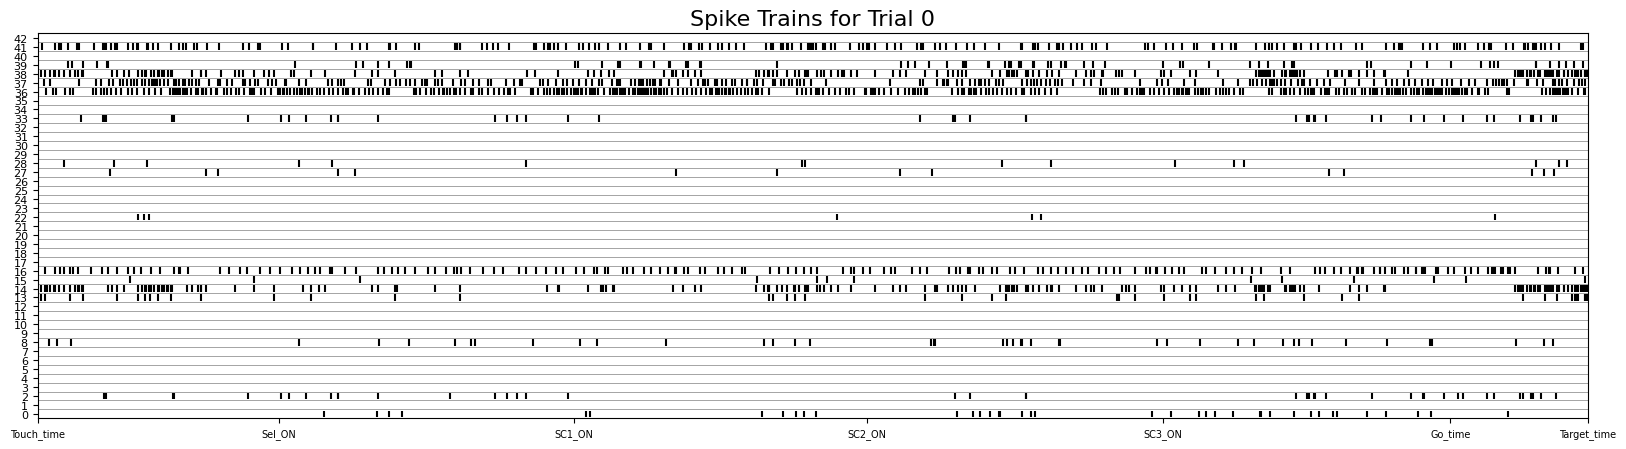

In [39]:
n_neurons = spikes_times_aligned.shape[0]

t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(20, 5))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# ISI Draft

In [ ]:
from synchrony import ISI

In [ ]:
X_isi_ = np.zeros((n_trials), dtype=object)
row, col = np.triu_indices(n_neurons, k=1)
n_pairs = len(row)
ISI_distance = []
X_isi = []

for t in range(n_trials) : 
    n_times = spikes_times_aligned[0][t]['t_stop_aligned']
    X_isi_one_trial = np.zeros((n_neurons, n_times))
    for n in range(n_neurons) :
        x_isi = ISI.compute(spikes_times_aligned[n][t]) 
        X_isi_one_trial[n, :] = x_isi

    ISI_distance_one_trials = np.zeros((n_pairs, n_times))
    for n_p, (r,c) in enumerate(zip(row, col)):
        ISI_distance_one_trials[n_p,:] = ISI.distance(X_isi_one_trial[r, :], X_isi_one_trial[c, :])
    
    X_isi.append(X_isi_one_trial)
    ISI_distance.append(ISI_distance_one_trials)

In [ ]:
t = 120
neurons_ = [38,16]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) : 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {i}" for i in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

In [ ]:
plt.figure(figsize=(20, 4))
ISI_dist_mean = np.zeros([7000])
for t in range(n_trials):
  x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
  y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
  ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)
  ISI_dist_mean[:6700] += ISI_distance_[:6700]

  plt.plot(ISI_distance_)  
plt.plot(ISI_dist_mean/n_trials, linewidth=3, c='k') 

In [ ]:
t = 121
neurons_ = [0,13]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()
0
# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

# ISI Interpolation

In [ ]:
def get_max_length(n_trials, ISI_distance):
    time_ = np.zeros((n_trials), dtype=int)
    for t in range(n_trials): 
        time_[t] = ISI_distance[t].shape[1]
    max_length = np.max(time_)

    return max_length, time_

In [ ]:
def interpolate_ISI_distance(ISI_distance,  max_length):
    len_trial = ISI_distance.shape[0]
    ISI_distance_interp_ = np.full(max_length, np.nan)
    ISI_distance_interp_[:len_trial] = ISI_distance
    return ISI_distance_interp_

def interpolate_X_isi(X_isi,  max_length):
    len_trial = X_isi.shape[0]
    X_isi_interp_ = np.full(max_length, np.nan)
    X_isi_interp_ = np.full(max_length, np.nan)
    X_isi_interp_[:len_trial] = X_isi
    return X_isi_interp_

In [ ]:
max_length, time = get_max_length(n_trials, ISI_distance)
ISI_distance_interp = np.zeros((n_trials, max_length, n_pairs), dtype=np.float32)
X_isi_interp = np.zeros((n_trials, max_length, n_neurons), dtype=np.float32)


for t in range(n_trials):
        for p in range(n_pairs):
                ISI_distance_interp[t, :, p]  = interpolate_ISI_distance(ISI_distance[t][p], max_length)
        for n in range(n_neurons) : 
                X_isi_interp[t, :, n] = interpolate_X_isi(X_isi[t][n], max_length)
        

In [ ]:
ISI_distance_interp.shape

In [ ]:
t = 120
neurons_ = [0,1]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))
sns.despine()
# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()
0
# Plot isi_dist in the second column
axs[2].plot(ISI_distance_interp[t,:,0], color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_interp[t,:,0].shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_interp[t,:,0].shape[0] + 500)  # Set x-axis limits



In [ ]:
t = 121
neurons_ = [0,1]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3, 1, figsize=(20, 8))
sns.despine()

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')

for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)

x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)

# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color='green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_interp[t,:,0], color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_interp[t,:,0].shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_interp[t,:,0].shape[0] + 500)  # Set x-axis limits

# Remove gridlines from all subplots
for ax in axs:
    ax.grid(False)

plt.show()


# Classif 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

In [ ]:
# Build pipeline
# Build pipeline
n_splits = 5
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
scaler = StandardScaler()
estimator = HistGradientBoostingClassifier()
clf = make_pipeline(scaler, estimator)

In [ ]:
target = pd.DataFrame(target_info[completeUnit][1]['Trial_type'], columns=['trial_type'])
target['position'] = list_position[completeUnit]

n_times = list(np.arange(0, ISI_distance_interp.shape[1], 100))
n_bins = len(n_times)

In [ ]:
# Initialiser une liste vide pour stocker les moyennes de bin
ISI_mean_bin = []

# Calculer les moyennes pour chaque bin et chaque paire
for start, end in zip(n_times[:-1], n_times[1:]):
    # Extraire les données pour le bin actuel
    bin_data = ISI_distance_interp[:, start:end, :]
    # Calculer la moyenne sur l'axe des temps
    bin_mean = np.nanmean(bin_data, axis=1)
    # Convertir les moyennes en DataFrame et les ajouter à la liste
    bin_mean_df = pd.DataFrame(bin_mean)
    ISI_mean_bin.append(bin_mean_df)

In [ ]:
class Model_info:

    def __init__(self, n_splits, n_events, data, target, cvs, clf):
        self.n_splits = n_splits
        self.n_periods = n_events
        self.data = data
        self.target = target
        self.cvs = cvs
        self.clf = clf

In [ ]:
list_ID_model = []

for idx, t in enumerate(n_times[:-1]):
    model_ID = Model_info(n_splits,\
             n_bins, ISI_mean_bin[idx], target['position'], cvs0, clf)
    list_ID_model.append(model_ID)

In [ ]:
list_ID_model[0].target

In [ ]:
list_ID_model[1].data

In [ ]:
acc_df = pd.DataFrame(columns=['split', 'data_type', 'time', 'target_type', 'accuracy'])
data_ = list_ID_model[0].data
target_ = list_ID_model[0].target
for i_split, (train_ind, test_ind) in enumerate(cvs0.split(data_, target_)):
    print('#################')
    print('SPLIT :', i_split)
    print('##################')
    
    for idx, t in enumerate(n_times[:-1]):
        model = list_ID_model[idx]
        data = model.data
        target = model.target

        # Train classifier 
        model.clf.fit(data.loc[train_ind, :], target.loc[train_ind].values.ravel())
    
        # Test classifier 
        y_pred = model.clf.predict(data.loc[test_ind, :])
        y_true = target.loc[test_ind].values
        acc = model.clf.score(data.loc[test_ind,:], target_.loc[test_ind])

        # Save test performance
        d = {
            'split': i_split,
            'data_type': 'test',
            'time': [t],
            'target_type': target.name, 
            'accuracy': acc,
        }

        acc_df = pd.concat((acc_df, pd.DataFrame(data=d)))
    
        # Train classifier on shuffled data
        ind_train_shuf = np.random.permutation(train_ind)
        model.clf.fit(data.loc[train_ind, :], target.loc[ind_train_shuf].values.ravel())
    
        # Test classifier on shuffled data
        y_pred_shuf = model.clf.predict(data.loc[test_ind, :])
        acc_shuf = model.clf.score(data.loc[test_ind,:], target_.loc[test_ind])
        
        # Save shuffled performance
        d_shuff = {
            'split': i_split,
            'data_type': 'shuff',
            'time': [t],
            'target_type': target.name, 
            'accuracy': acc_shuf
        }
        acc_df = pd.concat((acc_df, pd.DataFrame(data=d_shuff)), ignore_index=True)


In [ ]:
acc_df.to_csv(f'{result_path}/{session}_{classif}_{measure}_position.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Séparez les données par type
test_data = acc_df[acc_df['data_type'] == 'test']
shuff_data = acc_df[acc_df['data_type'] == 'shuff'] 

# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les données
plt.figure(figsize=(10, 6))

# Tracer les données de test
sns.lineplot(data=test_data, x='time', y='accuracy', marker='o', linestyle='-', label='Test Data')

# Tracer les données de shuffled
sns.lineplot(data=shuff_data, x='time', y='accuracy', marker='x', linestyle='--', label='Shuffled Data')

# Définir les étiquettes d'axe et le titre
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Time')

# Afficher la légende
plt.legend()

# Afficher le tracé
plt.show()
